# Approach (modeling)

DoA for scattering point 1: -12.09 degrees
DoA for scattering point 2: -12.58 degrees


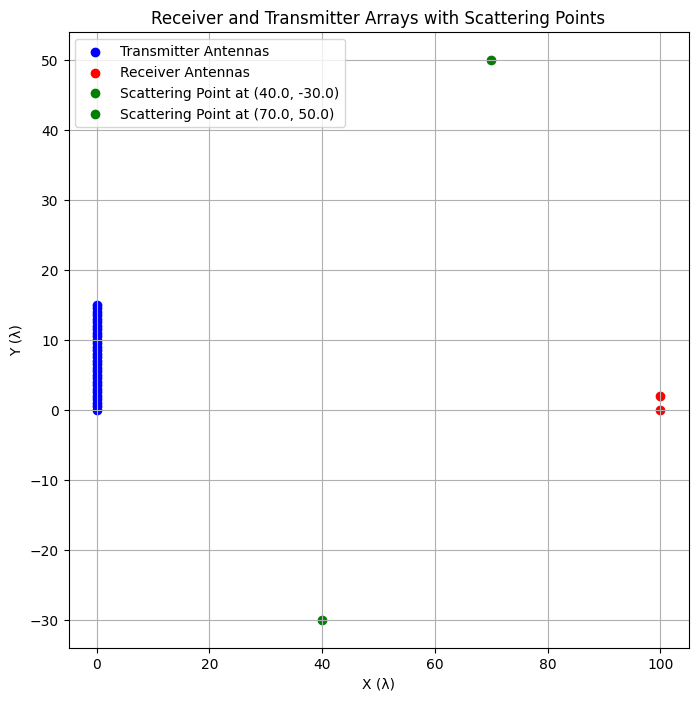

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
lambda_ = 1  # Wavelength (normalized)
d_t = lambda_ / 2  # Transmitter element spacing
d_r = 2 * lambda_  # Receiver element spacing
M = 31  # Transmitter elements
N = 2  # Receiver elements
l = 100 * lambda_  # Distance between receiver and transmitter

# Scattering points (x, y)
scattering_points = np.array([[40 * lambda_, -30 * lambda_],
                              [70 * lambda_, 50 * lambda_]])

# Function to calculate the steering vector
def steering_vector(N, d, theta, lambda_):
    k = 2 * np.pi / lambda_  # Wavenumber
    n = np.arange(N)
    return np.exp(1j * k * d * n * np.sin(theta))

# Calculate angle from (x, y) coordinates
def calculate_angle(x, y, l):
    return np.arctan2(y, x + l)  # Using the formula for angle from the x-y position

# Directions of arrival for the scattering points
angles = np.array([calculate_angle(pt[0], pt[1], l) for pt in scattering_points])

# Compute steering vectors for the receiver array
A_r = np.array([steering_vector(N, d_r, angle, lambda_) for angle in angles])

# For DoA estimation, let's focus on the case when two antennas are activated.
# We'll compute the phase difference between two antennas for each scattering point.

def compute_doa(A_r, M):
    doa_estimations = []
    for i in range(len(angles)):
        # Assume two antennas activated at a time (for simplicity, first and second)
        phase_diff = np.angle(A_r[i][1] / A_r[i][0])  # Phase difference between two antennas
        doa = np.degrees(np.arcsin(phase_diff / (2 * np.pi * d_r / lambda_)))  # Compute the angle
        doa_estimations.append(doa)
    return doa_estimations

# Compute DoA for the given scattering points
doa_estimations = compute_doa(A_r, M)

# Print results
for i, doa in enumerate(doa_estimations):
    print(f"DoA for scattering point {i + 1}: {doa:.2f} degrees")

# Plotting the positions of the antennas and scattering points
fig, ax = plt.subplots(figsize=(8, 8))

# Plot receiver and transmitter arrays as dots
ax.scatter([0]*M, np.arange(M)*d_t, label="Transmitter Antennas", color='blue')
ax.scatter([l]*N, np.arange(N)*d_r, label="Receiver Antennas", color='red')

# Plot scattering points
for pt in scattering_points:
    ax.scatter(pt[0], pt[1], color='green', label=f"Scattering Point at ({pt[0]/lambda_}, {pt[1]/lambda_})")

ax.set_xlabel('X (λ)')
ax.set_ylabel('Y (λ)')
ax.set_title('Receiver and Transmitter Arrays with Scattering Points')
ax.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import scipy.optimize as opt

# Define random matrix A and B
np.random.seed(42)  # for reproducibility
N = 31  # size of x1 and x2
m = 10**(-30 / 10)  # -40 dB in linear scale, m = 0.01
A = np.random.rand(N, N)  # random matrix A (size N x N)
B = np.random.rand(N, N)  # random matrix B (size N x N)

# Perform Singular Value Decomposition
U, S, Vh = np.linalg.svd(A)

u1 = U[0]
u2 = U[1]
#u3 = U[2] 
# Convert S to a diagonal matrix
Sigma = np.zeros_like(A, dtype=complex)
Sigma[:len(S), :len(S)] = np.diag(S)

# Display the results
# print("Matrix A:")
# print(A)
# print("\nU (Left Singular Vectors):")
# print(U)
#print("\nSigma (Singular Values):")
#print(Sigma)
#print("\nV^H (Right Singular Vectors):")
#print(Vh)

# Define target vectors u1 and u2
#u1 = np.random.rand(N)
#u2 = np.random.rand(N)

# Define the function for the L2 norm cost
def cost_function(x):
    x1 = x[:N]
    x2 = x[N:]
    term1 = np.linalg.norm(np.dot(A, x1) - u1)
    term2 = np.linalg.norm(np.dot(A, x2) - u2)
    return term1 + term2

# Define the constraint function for B
def constraint_function(x):
    x1 = x[:N]
    x2 = x[N:]
    
    # Compute the transformations for the constraints
    B_x1_x2 = np.dot(B, x1 + x2)  # transformation for x1 + x2
    B_x1_x2_2 = np.dot(B, x1 + x2 * np.exp(1j * np.pi / 2))  # transformation for x1 + x2 * exp(j*pi/2)
    B_x1_x2_3 = np.dot(B, x1 + x2 * np.exp(1j * np.pi))  # transformation for x1 + x2 * exp(j*pi)
    B_x1_x2_4 = np.dot(B, x1 + x2 * np.exp(1j * 3 * np.pi / 2))  # transformation for x1 + x2 * exp(j*3*pi/2)
    
    # Compute the absolute values and check if they are within the constraint
    constraint1 = np.abs(B_x1_x2) - m
    constraint2 = np.abs(B_x1_x2_2) - m
    constraint3 = np.abs(B_x1_x2_3) - m
    constraint4 = np.abs(B_x1_x2_4) - m
    
    # All constraints must be satisfied (should be >= 0)
    return np.concatenate([constraint1, constraint2, constraint3, constraint4])

# Initial guess for x1 and x2 (random initialization)
x_initial = np.random.rand(2 * N)

# Define the constraint bounds (for each constraint, the value must be non-negative)
constraints = {'type': 'ineq', 'fun': lambda x: constraint_function(x)}

# Run the optimization
result = opt.minimize(cost_function, x_initial, constraints=constraints, method='SLSQP')

# Check the result
if result.success:
    optimized_x = result.x
    x1_opt = optimized_x[:N]
    x2_opt = optimized_x[N:]
    print("Optimization successful!")
    print("Optimized x1:", x1_opt)
    print("Optimized x2:", x2_opt)
else:
    print("Optimization failed:", result.message)


Optimization successful!
Optimized x1: [-0.12641148 -0.05309955  0.11548234 -0.24036783  0.22335558  0.01519111
 -0.37149712 -0.05463584 -0.08585638 -0.06835164  0.01613833  0.02922096
  0.01680793  0.04006284 -0.02574827 -0.01962913  0.11274403 -0.31124388
  0.07493799 -0.01732154  0.14919153  0.0185937  -0.330605    0.07525077
  0.09698827 -0.01720246  0.46819822 -0.06480434  0.12462786 -0.02664797
  0.05131348]
Optimized x2: [ 0.33827385 -0.13468791 -0.18300492  0.37289527 -0.05140447  0.16672734
  0.37624122 -0.13358992 -0.04535386 -0.01153208 -0.19743318 -0.02742769
  0.00677219 -0.06916763 -0.15892534  0.06590506 -0.16668292  0.13685942
 -0.11481514  0.053806    0.0625029   0.0060997   0.18701705  0.19037614
 -0.10543709 -0.06218031 -0.16657406  0.03449044 -0.06972708 -0.00327923
  0.07373826]


# Random Results

(31, 100)


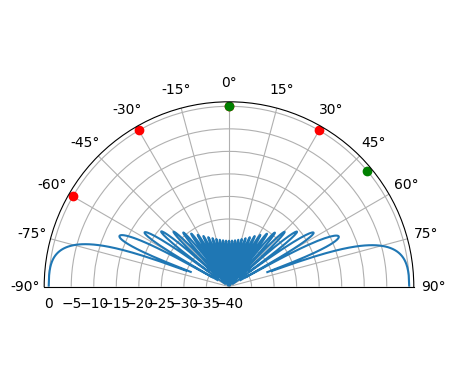

In [108]:
# Simulate received signal
Ts = 1000
t = np.arange(100)/Ts #size of the simulation
#print(t.shape)
Nr = 31 # Nt elements
def steering_vector(theta, N, d, k):
    theta_rad = np.radians(theta)  # Convert angle to radians
    n = np.arange(N)  # Element indices
    a = np.exp(1j * k * d * n * np.sin(theta_rad))  # Steering vector
    return a
N = 31
s = steering_vector(theta,N,d,k).reshape(-1,1)
tone = np.exp(2j*np.pi*0.01e6*t).reshape(1,-1)

#tone[0,:] = np.exp(2j*np.pi*0.01e6*t).reshape(1,-1)
#tone[1,:] = np.exp(2j*np.pi*0.01e6*t).reshape(1,-1)

X = s @tone
print(X.shape)
#n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
#X = X + 0.5*n # 8xN

# Let's point at the SOI at 15 deg, and another potential SOI that we didn't actually simulate at 60 deg
soi1_theta = 100/2 / 180 * np.pi # convert to radians
soi2_theta = 0 / 180 * np.pi

# LCMV weights
R_inv = np.linalg.pinv(np.cov(X)) # 8x8
#print(R_inv.shape)
s1 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(soi1_theta)).reshape(-1,1) # 8x1
s2 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(soi2_theta)).reshape(-1,1) # 8x1

#v1 = np.array([1, 2, 3, 4, 5, 6])  # Example vector v1, replace with your own values

# Define the size of the matrix (for example, 6x6 matrix with 5 unit vectors)
num_rows = 31
num_columns = 31

# Initialize the matrix with v1 as the first column
matrix = np.zeros((num_rows, num_columns))

# Set the first column to v1
matrix[:, 0] = x1_opt
matrix[:, 1] = x2_opt

# Add standard basis vectors to the rest of the columns
for i in range(2, num_columns):
    matrix[:, i] = np.zeros(num_rows)
    matrix[i-1, i] = 1  # Place the 1 in the appropriate position

# Print the resulting matrix
#print("Resulting matrix:")
#print(matrix)
C = matrix
#C = np.concatenate(s,array=1)#np.concatenate(s) # 8x2
#print(C.shape)
f = np.ones(2) # 2x1
f = np.append(f,np.zeros(29))
f = f.reshape(-1,1)
# LCMV equation
#    NtxNt   Ntx1                    1xNt        NtxNt   NtxNt  Ntx1
w = R_inv @ C @ np.linalg.pinv(C.conj().T @ R_inv @ C) @ f # output is Ntx1

# Plot beam pattern
w = w.squeeze() # reduce to a 1D array
N_fft = 1024
w = np.conj(w) # or else our answer will be negative/inverted
w_padded = np.concatenate((w, np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # Map the FFT bins to angles in radians

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
# Add dots where interferers and SOIs are
ax.plot([theta1], [0], 'or')
ax.plot([theta2], [0], 'or')
ax.plot([theta3], [0], 'or')
ax.plot([theta4], [0], 'or')
ax.plot([soi1_theta], [0], 'og')
ax.plot([soi2_theta], [0], 'og')
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_thetagrids(np.arange(-90, 105, 15)) # it's in degrees
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-40, 1]) #only go down 40 dB
plt.show()

(31, 1)
(1, 10000)
(10000,)
-180.0


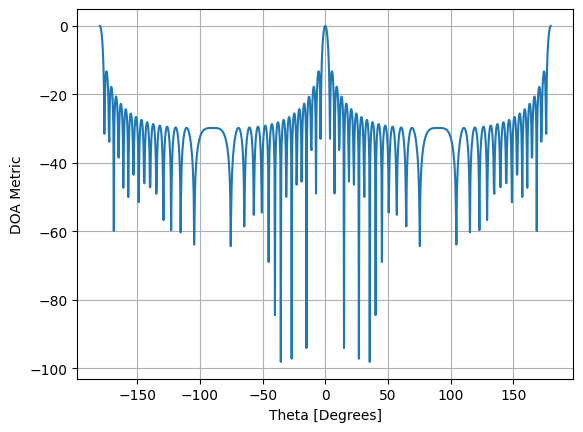

In [8]:
w = x1_opt;
##Received Signal
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
l = 10000 # number of samples to simulate

#Create a tone to act as the transmitter signal
t = np.arange(l)/sample_rate #time vector
f_tone = 0.02e6
tx = np.exp(2j*np.pi*f_tone*t)
tx = tx.reshape(1,-1)

# steering vector
d = d_t #half wavelength spacing
Nr = M # number of elements on the initial
theta_degrees  = 0 # direction of arrival
theta = theta_degrees / 180 *np.pi #radians conversion
s = np.exp(-2j*np.pi * d * np.arange(Nr)*np.sin(theta)) # Steering vector
s = s.reshape(-1,1)
#print(s) # 3D element long

print(s.shape)
print(tx.shape)
X = s @ tx


#delay and sum
#conventional, aka, delay-and-sum, beamformer
#w = np.exp(-2j*np.pi*d*np.arange(Nr)*np.sin(theta))

#Applying the weights to the received signal (i.e. perform the beamforming)           
X_weighted = w.conj().T @X 

print(X_weighted.shape) # 1x10000



#plot
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # 1000 different thetas between
results = []
for theta_i in theta_scan:
	w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Convetional, aka delay-and-sum, beamformer
	X_weighted = w.conj().T @X # apply our weights. remember X is 3x10000
	results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) #normalize (optional)

# print angle that gave us the max value
print(theta_scan[np.argmax(results)]*180/np.pi) #19.99

plt.plot(theta_scan*180/np.pi, results) #lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

# Convex Optimization

Combining results

(31, 31)
(31, 10000)


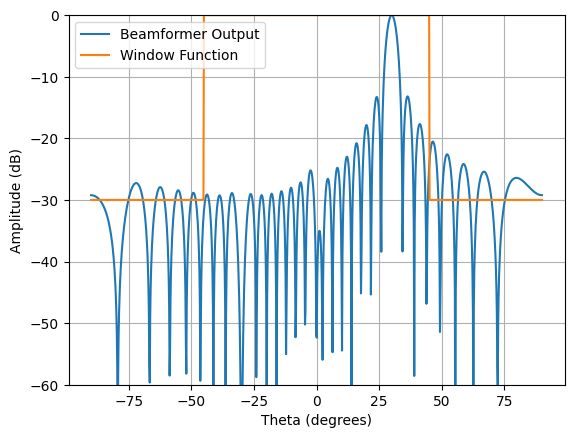

In [4]:
import numpy as np
import cvxpy as cp

# Constants
num_elements = 31  # Number of elements in the transmitter array
wavelength = 1  # Assume λ = 1 for simplicity
d = wavelength / 2  # Inter-element spacing

# Receiver and Scatterer Locations
receiver_angles = np.radians([-30, 0, 30])  # Convert degrees to radians
scatterers = np.array([[45, -30], [45, 30]])  # 40,70 -30,50 (x, y) in wavelengths

# Steering Vector Function
def steering_vector(theta, num_elements, d, wavelength):
    k = 2 * np.pi / wavelength
    positions = np.arange(num_elements) * d
    return np.exp(1j * k * positions * np.sin(theta))

# Construct the steering matrix A_hat
A_hat = np.column_stack([steering_vector(theta, num_elements, d, wavelength) for theta in receiver_angles])

# Define Optimization Variables
x1 = cp.Variable(num_elements, complex=True)
x2 = cp.Variable(num_elements, complex=True)
x3 = cp.Variable(num_elements, complex=True)

# Canonical Basis Vectors (3D space)
u1 = np.array([1, 0, 0])
u2 = np.array([0, 1, 0])
u3 = np.array([0, 0, 1])

# Define the objective function
objective = cp.Minimize(
    cp.norm(A_hat.T @ x1 - u1, 2) ** 2 +
    cp.norm(A_hat.T @ x2 - u2, 2) ** 2 +
    cp.norm(A_hat.T @ x3 - u3, 2) ** 2
)

# Define Constraints
m_db = -30  # m in dB
m = 10 ** (m_db / 20)  # Convert dB to linear scale
QPSK_phases = np.array([0, np.pi/2, np.pi, 3*np.pi/2])

constraints = []
for phi in QPSK_phases:
    for psi in QPSK_phases:
        constraints.append(
            cp.norm(A_hat.T @ (x1 + x2 * np.exp(1j * phi) + x3 * np.exp(1j * psi)), 2) ** 2 <= m ** 2
        )

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Print results
# print("Optimal x1:", x1.value)
# print("Optimal x2:", x2.value)
# print("Optimal x3:", x3.value)

w = x3.value#+ x2.value+x3.value;

#print("Weights:", w)
##Received Signal
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
l = 10000 # number of samples to simulate

#Create a tone to act as the transmitter signal
t = np.arange(l)/sample_rate #time vector
f_tone = 0.02e6
tx = np.exp(2j*np.pi*f_tone*t)
tx = tx.reshape(1,-1)

# steering vector
d = d_t #half wavelength spacing
Nr = M # number of elements on the initial
theta_degrees  = 0 # direction of arrival
theta = theta_degrees / 180 *np.pi #radians conversion
s = np.exp(-2j*np.pi * d * np.arange(Nr)*np.sin(theta)) # Steering vector
s = s.reshape(-1,1)
#print(s) # 3D element long

f = np.zeros((len(s),len(s)),complex)
#f = f.reshape(1,-1)
#f = f.reshape(-1,1)
print(f.shape)
for i in range(len(w)):
    f[i][i] = w[i]

s = f@s
#print(s)

#wait = input('Press a button to continue')

#print(f.shape)
#print(s.shape)
#print(tx.shape)
X = s @ tx


#delay and sum
#conventional, aka, delay-and-sum, beamformer
#w = np.exp(-2j*np.pi*d*np.arange(Nr)*np.sin(theta))

#Applying the weights to the received signal (i.e. perform the beamforming)           
#X_weighted = w.conj().T @X 
X_weighted = X
print(X_weighted.shape) # 1x10000

#plot
theta_scan = np.linspace(-1*np.pi/2, np.pi/2, 1000) # 1000 different thetas between
results = []
for theta_i in theta_scan:
	w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Convetional, aka delay-and-sum, beamformer
	X_weighted = w.conj().T @X # apply our weights. remember X is 3x10000
	results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) #normalize (optional)


#Generating window
def window_function(theta):
    window = np.zeros_like(theta)
    window[np.abs(theta * 180 / np.pi) <= 45] = 1  # Inside -45 to 45 degrees
    window[np.abs(theta * 180 / np.pi) > 45] = 10**(-30/20)  # Outside -45 to 45 degrees, converting dB to linear scale
    return window

# print angle that gave us the max value
#print(theta_scan[np.argmax(results)]*180/np.pi) #19.99
window_values = window_function(theta_scan)


# print angle that gave us the max value
# print(theta_scan[np.argmax(results)]*180/np.pi) #19.99

# plt.plot(theta_scan*180/np.pi, results) #lets plot angle in degrees
# plt.xlabel("Theta [Degrees]")
# plt.ylabel("DOA Metric")
# plt.grid()
# plt.show()
# Plotting
plt.plot(theta_scan * 180 / np.pi, results, label='Beamformer Output')
plt.plot(theta_scan * 180 / np.pi, 20 * np.log10(window_values), label='Window Function')
plt.xlabel('Theta (degrees)')
plt.ylabel('Amplitude (dB)')
plt.ylim([-60, 0])
plt.legend()
plt.grid(True)
plt.show()